In [4]:
!pip install xgboost

In [2]:
import math
import pandas as pd
import sklearn 
from sklearn import preprocessing, linear_model, metrics, model_selection
import matplotlib.pyplot as plt

TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

In [3]:
train_data = pd.read_csv(TRAIN_FILE)
test_data = pd.read_csv(TEST_FILE)

In [4]:
train_data.head(5)

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
1,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
2,6,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
3,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
4,9,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93,16.5


In [5]:
train_data.isna().sum()

ID         0
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [6]:
train_data.describe()

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.00000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000
mean,246.082237,3.524859,12.483553,10.708092,0.055921,0.54926,6.287595,67.535526,3.888100,9.450658,406.776316,18.383553,356.275789,12.559770,22.908882
std,146.107684,8.192917,24.556758,6.757236,0.230148,0.11447,0.739903,28.353973,2.154522,8.669445,166.510516,2.225948,94.917336,7.175961,9.387933
min,2.000000,0.009060,0.000000,0.740000,0.000000,0.38500,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,2.520000,1.730000,5.000000
25%,119.750000,0.081348,0.000000,4.930000,0.000000,0.44800,5.875750,41.850000,2.116900,4.000000,279.000000,16.800000,376.737500,6.927500,17.800000
50%,241.500000,0.226825,0.000000,8.560000,0.000000,0.52400,6.211000,74.850000,3.317500,5.000000,330.000000,18.700000,391.770000,10.990000,21.500000
75%,376.250000,3.525265,20.000000,18.100000,0.000000,0.62400,6.618250,93.125000,5.287300,24.000000,666.000000,20.200000,396.060000,16.530000,26.450000
max,506.000000,73.534100,100.000000,27.740000,1.000000,0.87100,8.780000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
# 指定子圖的佈局

#feature_name = 'crim'
#y_name = 'medv'

def plot_stats_graph(t_data, feature_name,y_name, outlier_proc = False) :
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    data = t_data.copy()
    if outlier_proc == True:
        l_q = data[feature_name].quantile(0.10)
        u_q = data[feature_name].quantile(0.80)

        data.loc[data[feature_name] <= l_q, feature_name] = l_q
        data.loc[data[feature_name] >= u_q, feature_name] = u_q

    mean_b = data.groupby(pd.cut(data[feature_name], 10)).mean()
    # 繪製子圖1：直方圖
    # axs[0, 0].hist(data[feature_name], bins=10)
    # axs[0, 0].set_title(feature_name + ' Distribution')

    # 绘制左轴（A的直方图）
    ax1 = axs[0, 0]

    ax1.hist(data[feature_name], bins=10, alpha=0.5)
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of '+feature_name)

    # 创建右轴（B的平均值）
    ax2 = ax1.twinx()
    ax2.plot(mean_b.index.categories.mid, mean_b[y_name], color='r', marker='o')
    ax2.set_ylabel('Mean of '+y_name)

    # 繪製子圖2：箱線圖
    axs[0, 1].boxplot(data[feature_name])
    axs[0, 1].set_title(feature_name + ' Distribution')

    # 繪製子圖3：散點圖
    axs[1, 0].scatter(data[feature_name], data[y_name])
    axs[1, 0].set_title(feature_name + ' vs ' + y_name)

    # 繪製子圖4：核密度估計圖
    data[feature_name].plot.kde(ax=axs[1, 1])
    axs[1, 1].set_title(feature_name + ' Distribution')

    # 調整子圖間的間距
    plt.tight_layout()

    # 顯示圖形
    plt.show()



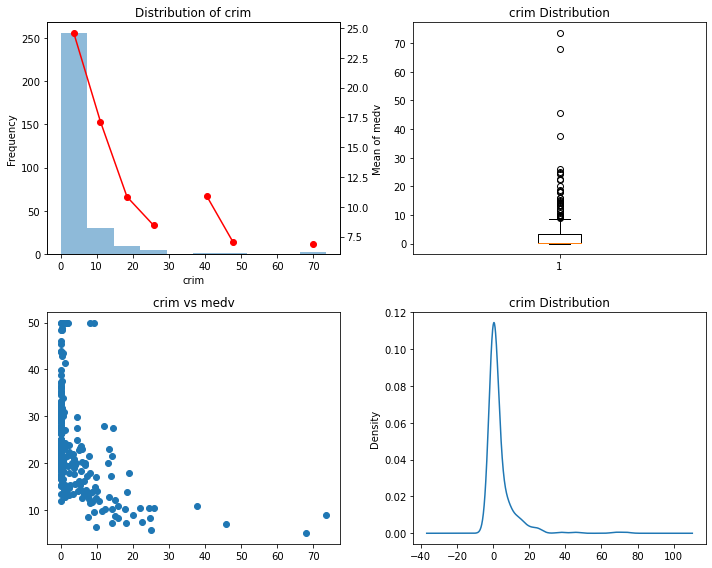

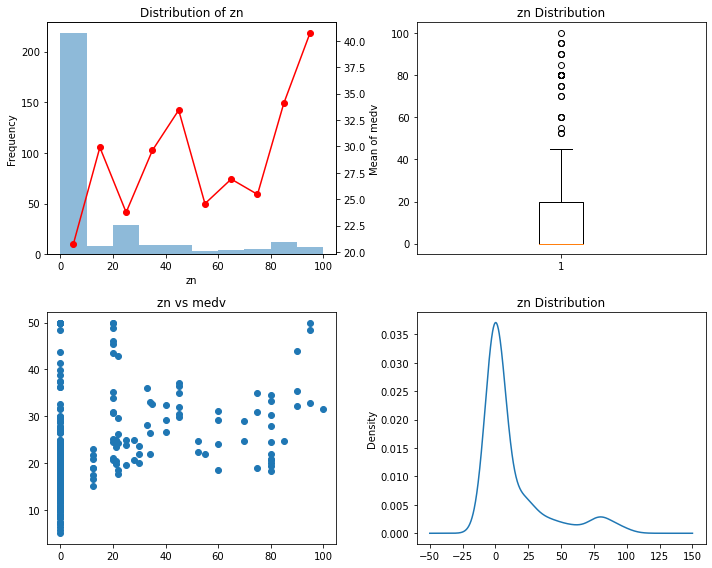

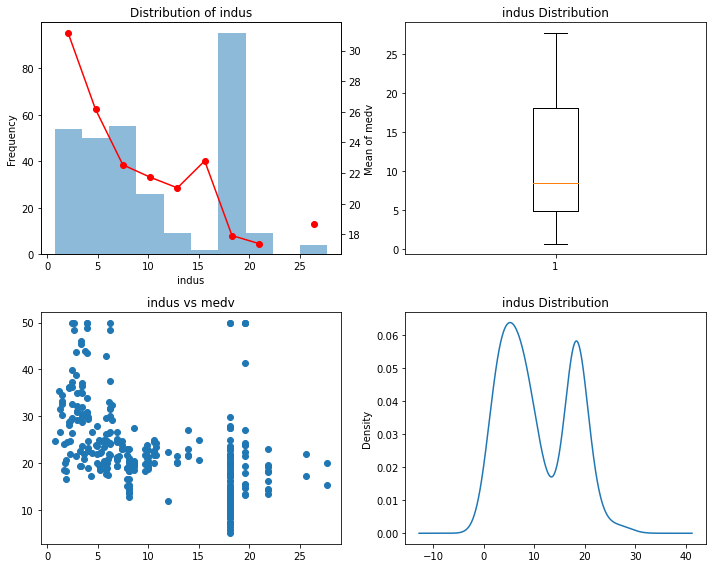

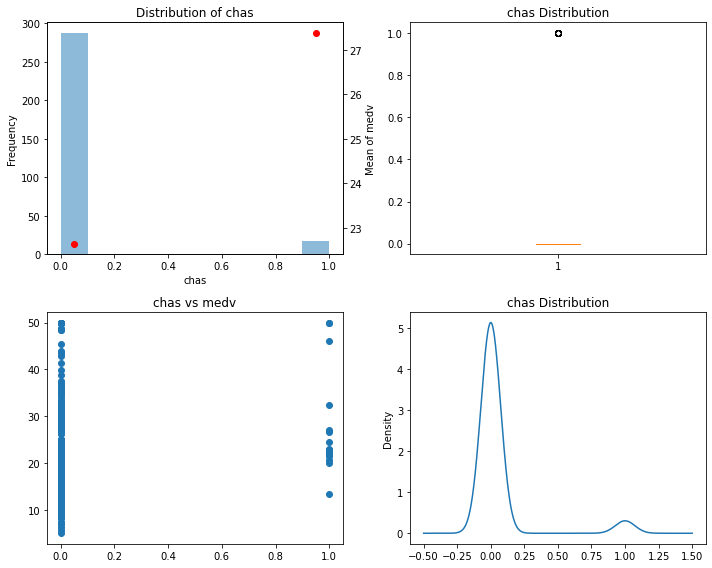

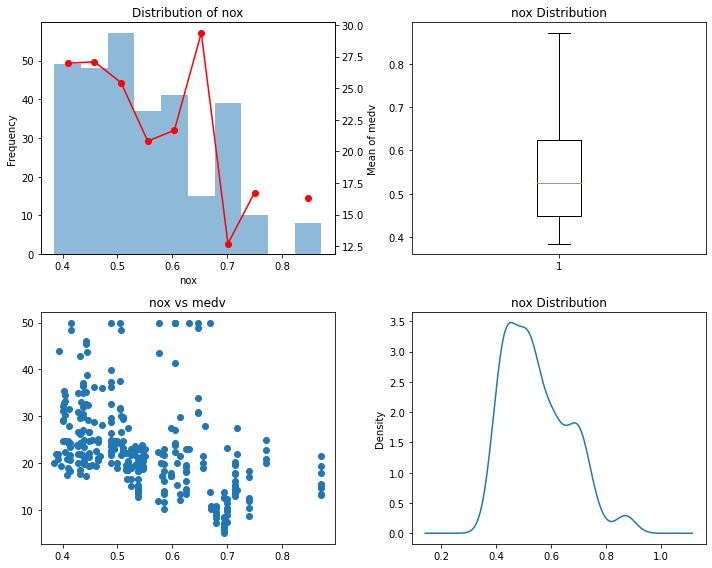

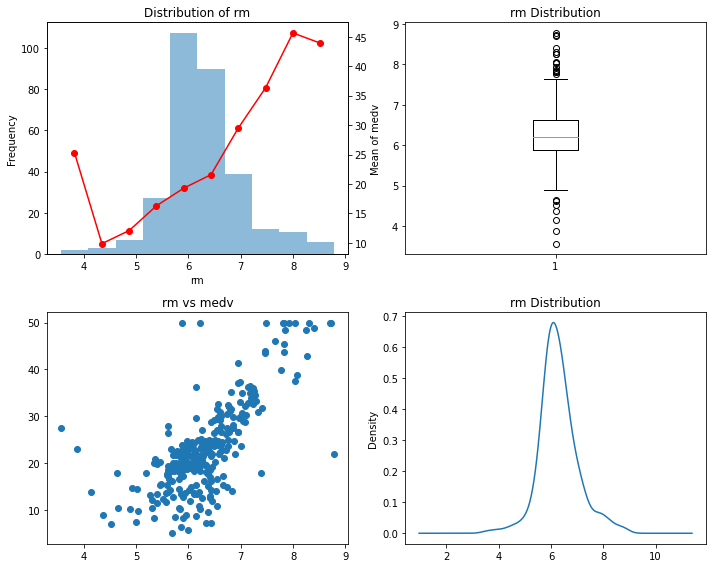

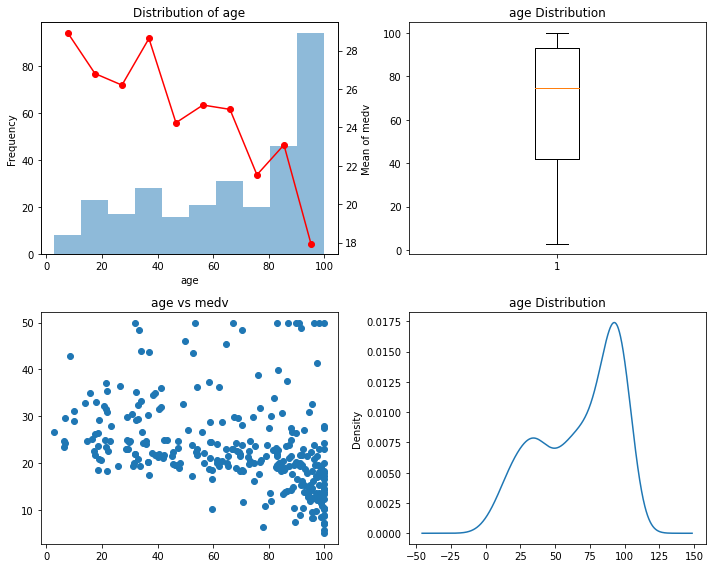

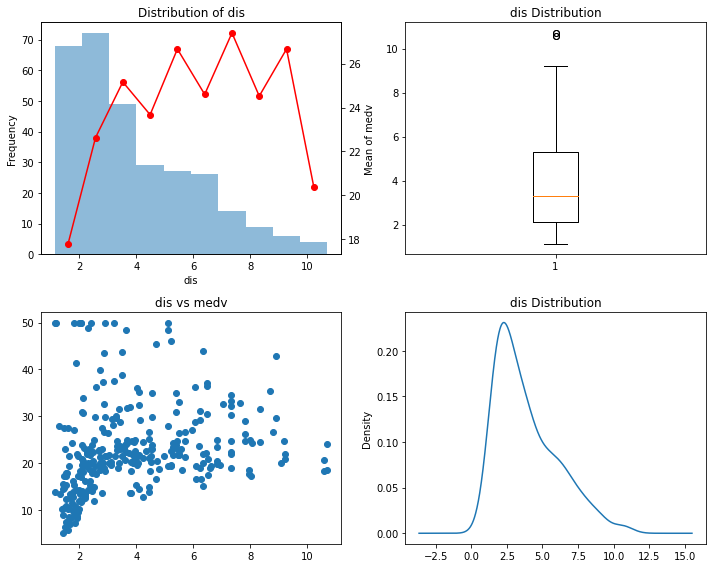

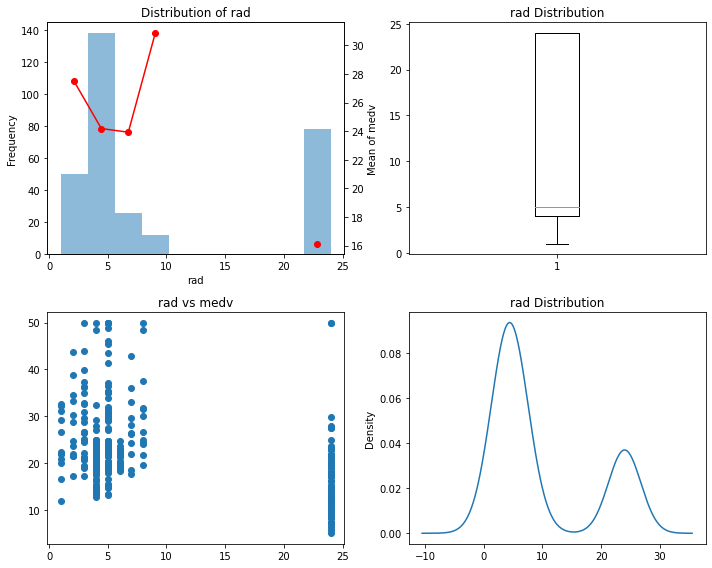

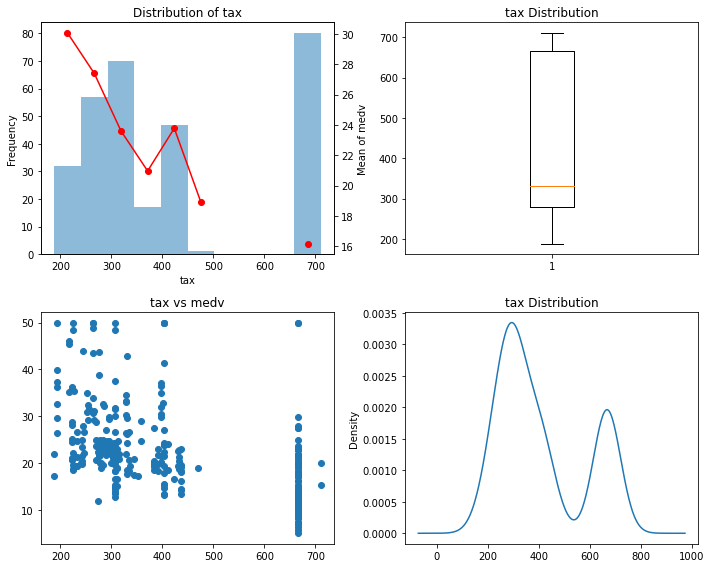

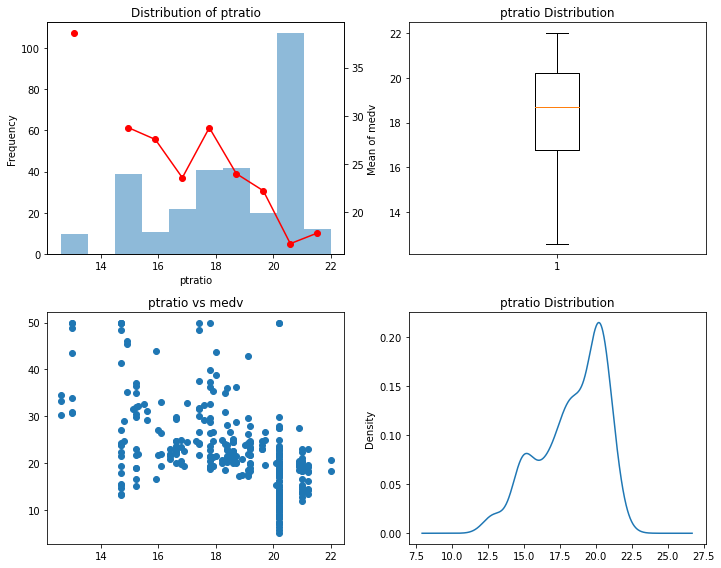

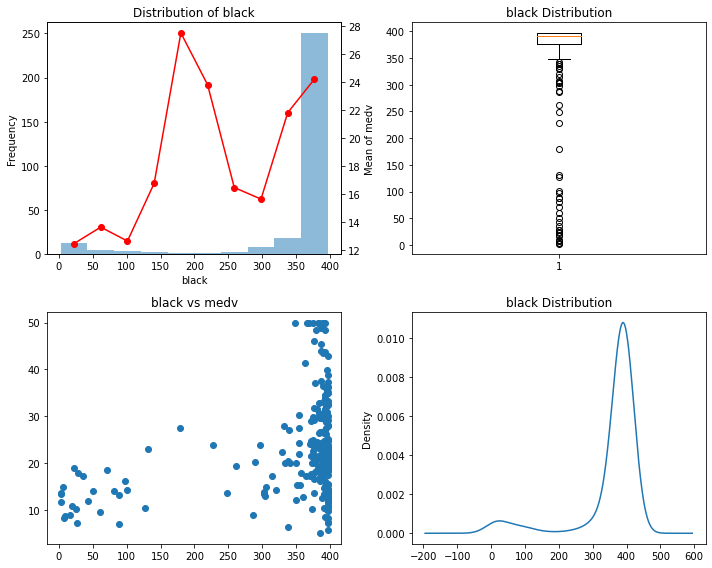

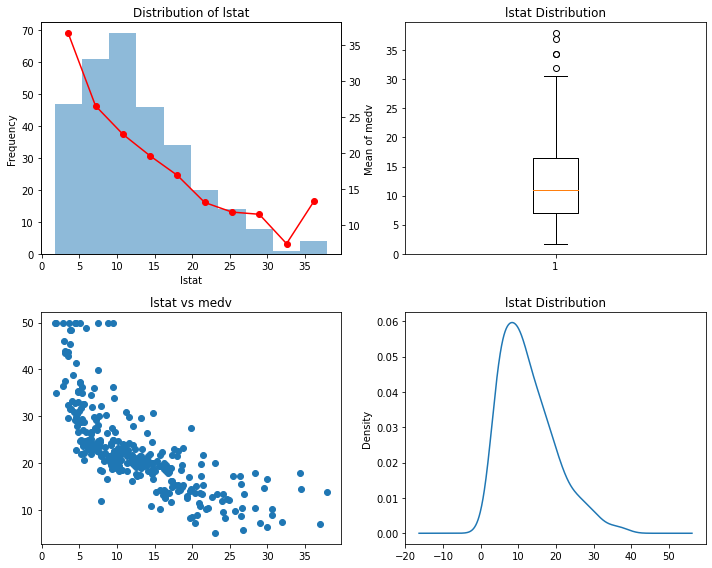

In [8]:
f_name_list = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad',
       'tax', 'ptratio', 'black', 'lstat']

prep_rob_train_data_X = preprocessing.StandardScaler().fit_transform(train_data[f_name_list])
prep_rob_train_data_X_df = pd.DataFrame(prep_rob_train_data_X, columns=f_name_list)
prep_rob_train_data_X_df['medv'] = train_data['medv']

for f in f_name_list:
    plot_stats_graph(train_data, f, 'medv')

#for f in f_name_list:
#    plot_stats_graph(prep_rob_train_data_X_df, f, 'medv')



In [9]:
feature = train_data.columns.drop(['ID','medv'])

t_data = train_data[feature]
t_labels = train_data['medv']

X_train, X_val, y_train,y_val = model_selection.train_test_split(t_data, t_labels, test_size=0.2, random_state=2)

Create Pipeline

# https://towardsdatascience.com/step-by-step-tutorial-of-sci-kit-learn-pipeline-62402d5629b6

In [10]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


#defune 
numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='mean'))
      ,('scaler', MinMaxScaler())
      ,('poly', PolynomialFeatures(1))
])
categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant'))
      ,('encoder', OrdinalEncoder())
])

numeric_features = ['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad',
       'tax', 'ptratio', 'black', 'lstat']

categorical_features = []

#ColumnTransformer can perform different preprocessing steps due to different data types
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
]) 

Base models

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

regressors = [
   LinearRegression(), 
   RandomForestRegressor(), 
   AdaBoostRegressor(), 
   BaggingRegressor(),
   GradientBoostingRegressor(),
   XGBRegressor(eval_metric='rmse')]

#feature_selector = SelectKBest(k=3)

for r in regressors:

   pipeline = Pipeline(steps = [
                  ('preprocessor', preprocessor)
               #, ('feature_selection', feature_selector)
               ,('regressor',r)
            ])
   pipeline.fit(X_train, y_train)
   train_pre = pipeline.predict(X_train)
   val_pre = pipeline.predict(X_val)
   
   print(r)
   print(metrics.mean_squared_error(train_pre, y_train)**0.5)
   print(metrics.mean_squared_error(val_pre, y_val)**0.5)


LinearRegression()
4.904041264362609
4.619140964811747
RandomForestRegressor()
1.432716766612763
3.022616820343417
AdaBoostRegressor()
2.7267309700185587
3.1406924090871047
BaggingRegressor()
1.6100948263360881
3.2947427074350912
GradientBoostingRegressor()
1.0153122795851448
3.156179989494142
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             pr

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import statistics

regressors = [
    RandomForestRegressor()
    #XGBRegressor(eval_metric='rmse')
    ]

selector = RFECV(RandomForestRegressor(), step=1, cv=3)
#feature_selector = SelectKBest(k=3)

p_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for p in p_list:
    x = 3
    t_score = []
    v_score = []
    while x >= 0:
        
        X_train, X_val, y_train,y_val = model_selection.train_test_split(t_data, t_labels, test_size=p)

        pipeline = Pipeline(steps = [
                    ('preprocessor', preprocessor),
                    ('select', selector), 
                    ('regressor',r)
                ])
        
        pipeline.fit(X_train, y_train)
        train_pre = pipeline.predict(X_train)
        val_pre = pipeline.predict(X_val)

        t_score.append(metrics.mean_squared_error(train_pre, y_train)**0.5)
        v_score.append(metrics.mean_squared_error(val_pre, y_val)**0.5)
        x -=1
    
    #print(x)
    #print ('Train:', p, ' Avg:', statistics.mean(t_score), ' stdev:', statistics.stdev(t_score))
    print ('Val:', p, ' Avg:', statistics.mean(v_score), ' stdev:', statistics.stdev(v_score))        

Val: 0.05  Avg: 3.3702821340016267  stdev: 0.4999212354740232
Val: 0.1  Avg: 4.083341483920351  stdev: 0.5945312773205648
Val: 0.15  Avg: 4.406496224816935  stdev: 1.9187032644262993
Val: 0.2  Avg: 3.653838372096131  stdev: 1.0422537739680868
Val: 0.25  Avg: 3.7439942514908293  stdev: 0.3572096002450114
Val: 0.3  Avg: 4.721897197799063  stdev: 0.6976907431827974


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
import statistics

regressors = [
    #RandomForestRegressor()
    XGBRegressor(eval_metric='rmse')
    ]

selector = RFECV(XGBRegressor(), step=1, cv=3)
#feature_selector = SelectKBest(k=3)

p_list = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for p in p_list:
    x = 3
    t_score = []
    v_score = []
    while x >= 0:
        
        X_train, X_val, y_train,y_val = model_selection.train_test_split(t_data, t_labels, test_size=p)

        pipeline = Pipeline(steps = [
                    ('preprocessor', preprocessor),
                    ('select', selector), 
                    ('regressor',r)
                ])
        
        pipeline.fit(X_train, y_train)
        train_pre = pipeline.predict(X_train)
        val_pre = pipeline.predict(X_val)

        t_score.append(metrics.mean_squared_error(train_pre, y_train)**0.5)
        v_score.append(metrics.mean_squared_error(val_pre, y_val)**0.5)
        x -=1
    
    #print(x)
    #print ('Train:', p, ' Avg:', statistics.mean(t_score), ' stdev:', statistics.stdev(t_score))
    print ('Val:', p, ' Avg:', statistics.mean(v_score), ' stdev:', statistics.stdev(v_score))        

Val: 0.05  Avg: 3.6101998502626245  stdev: 1.561350881370926
Val: 0.1  Avg: 4.353693179058742  stdev: 0.7432577004628693
Val: 0.15  Avg: 4.169337658832262  stdev: 1.0870559972830707
Val: 0.2  Avg: 4.192328319136171  stdev: 1.017937346567102
Val: 0.25  Avg: 4.013501465063629  stdev: 0.8128471268065939
Val: 0.3  Avg: 3.9706117868472406  stdev: 0.49651830136666997
Val: 0.35  Avg: 4.346679856143507  stdev: 1.0391399477353114
Val: 0.4  Avg: 3.753264096695994  stdev: 0.35219831165754134
Val: 0.45  Avg: 4.343860850602532  stdev: 0.2226444592091089
Val: 0.5  Avg: 4.31425002534132  stdev: 0.6828226806191161
Val: 0.55  Avg: 4.551725983932575  stdev: 0.4604422438325634
Val: 0.6  Avg: 4.17093744944796  stdev: 0.49754541977049715
Val: 0.65  Avg: 4.717245482967668  stdev: 0.5633953733982292
Val: 0.7  Avg: 4.845295549908023  stdev: 0.5092559340189089
Val: 0.75  Avg: 5.028382735849887  stdev: 0.21772157032417053
Val: 0.8  Avg: 4.993171413184177  stdev: 0.2935770517784987
Val: 0.85  Avg: 5.306385656912

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import G

# Create a feature selection transformer
# selector = SelectFromModel(estimator=xgb.XGBRegressor())

feature = train_data.columns.drop(['ID','medv'])

t_data = train_data[feature]
t_labels = train_data['medv']

X_train, X_val, y_train,y_val = model_selection.train_test_split(t_data, t_labels, test_size=0.2, random_state=2)

preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_val = preprocessor.transform(X_val)

# Convert the data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Regression task with mean squared error
    'eval_metric': 'rmse',  # Evaluation metric is root mean squared error
    'max_depth': 5,  # Maximum depth of each tree
    'subsample': 0.8,  # Fraction of training samples used for each tree
    'colsample_bytree': 0.8,  # Fraction of features used for each tree
    'reg_alpha': 0.1,  # L1 regularization term
    'reg_lambda': 0.1,  # L2 regularization term
    'min_child_weight': 1,  # Minimum sum of instance weight required to create a new node
    'gamma': 0.1,  # Minimum loss reduction required to make a further partition on a leaf node
    'eta': 0.0001  # Learning rate
}

# Train the model with early stopping
model = xgb.train(params, dtrain,
                  num_boost_round=100000,  # Maximum number of boosting rounds
                  early_stopping_rounds=10,  # Stop if the metric doesn't improve for 10 rounds
                  evals=[(dval, 'validation')],  # Validation dataset
                  verbose_eval=True)

# Make predictions on the validation set
#y_pred = model.predict(dval)

# Calculate RMSE
#rmse = mean_squared_error(y_val, y_pred, squared=False)
#print("RMSE:", rmse)

train_pre = model.predict(dtrain)
val_pre = model.predict(dval)

print(r)
print(metrics.mean_squared_error(train_pre, y_train)**0.5)
print(metrics.mean_squared_error(val_pre, y_val)**0.5)

[0]	validation-rmse:24.35861
[1]	validation-rmse:24.35638
[2]	validation-rmse:24.35401
[3]	validation-rmse:24.35167
[4]	validation-rmse:24.34935
[5]	validation-rmse:24.34705
[6]	validation-rmse:24.34469
[7]	validation-rmse:24.34246
[8]	validation-rmse:24.34018
[9]	validation-rmse:24.33784
[10]	validation-rmse:24.33553
[11]	validation-rmse:24.33323
[12]	validation-rmse:24.33088
[13]	validation-rmse:24.32851
[14]	validation-rmse:24.32610
[15]	validation-rmse:24.32369
[16]	validation-rmse:24.32138
[17]	validation-rmse:24.31914
[18]	validation-rmse:24.31691
[19]	validation-rmse:24.31460
[20]	validation-rmse:24.31229
[21]	validation-rmse:24.30990
[22]	validation-rmse:24.30761
[23]	validation-rmse:24.30533
[24]	validation-rmse:24.30302
[25]	validation-rmse:24.30074
[26]	validation-rmse:24.29843
[27]	validation-rmse:24.29610
[28]	validation-rmse:24.29374
[29]	validation-rmse:24.29144
[30]	validation-rmse:24.28905
[31]	validation-rmse:24.28671
[32]	validation-rmse:24.28439
[33]	validation-rmse

In [ ]:

from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import SelectFromModel


X_train, X_val, y_train,y_val = model_selection.train_test_split(t_data, t_labels, test_size=0.2, random_state=2)


estimators = [
   ('xgb1', XGBRegressor()),  
   ('xgb2', XGBRegressor()), 
   ('xgb3', XGBRegressor()), 
   ('xgb4', XGBRegressor()),  
   ('xgb5', XGBRegressor()), 
   ('xgb6', XGBRegressor()), 
   ('xgb7', XGBRegressor()), 
   ('xgb8', XGBRegressor()), 
   ('xgb9', XGBRegressor()),
   ('xgb10', XGBRegressor())

    #('lr',  RidgeCV()),
    #('rf',  RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=0.05)),
    #('ada', AdaBoostRegressor(n_estimators=100)),
    #('bag', BaggingRegressor(n_estimators=200)),
    #('xgb', XGBRegressor(max_depth = 3, reg_lambda = 0.5, colsample_bytree = 1, reg_alpha = 0.1))
    #('rf1',  RandomForestRegressor()),
]
reg = StackingRegressor(
    estimators=estimators,
    #final_estimator=XGBRegressor()
    final_estimator=RandomForestRegressor(n_estimators=300, max_depth=5, min_samples_leaf=0.01)
)

param_grid = {
    #'reg__xgb__learning_rate': [0.1, 0.01],  # Learning rate
    #'reg__xgb__max_depth': [3, 5, 7],  # Maximum depth of a tree
    #'reg__xgb__n_estimators': [100, 200, 300],  # Number of trees
    #'reg__xgb__subsample': [0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    #'reg__xgb__colsample_bytree': [0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    #'reg__xgb__gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node
    #'reg__xgb__reg_alpha': [0, 0.1, 0.5]  # L1 regularization term on weights
    #'reg__xgb__reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
}

pipeline = Pipeline([
            ('preprocessor', preprocessor)
            ,('reg',reg)
        ])

#grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='neg_mean_squared_error')
#grid_search.fit(X_train, y_train)
#rf_model = grid_search.best_estimator_
rf_model = pipeline.fit(X_train, y_train)
train_pre = rf_model.predict(X_train)
val_pre = rf_model.predict(X_val)

print(metrics.mean_squared_error(train_pre, y_train)**0.5)
print(metrics.mean_squared_error(val_pre, y_val)**0.5)

1.616355227102512
2.9099684718951364


In [ ]:
test_pred_data = test_data.drop(['ID','medv'], axis = 1)
test_pre = rf_model.predict(test_pred_data).round(1)

test_data['medv'] = test_pre
pd.DataFrame(test_data[['ID', 'medv']]).to_csv('prediction.csv', index=False)

In [ ]:
test_data

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.8
1,3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,34.5
3,8,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15,17.8
4,16,0.62739,0.0,8.14,0,0.538,5.834,56.5,4.4986,4,307,21.0,395.62,8.47,20.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,500,0.17783,0.0,9.69,0,0.585,5.569,73.5,2.3999,6,391,19.2,395.77,15.10,20.4
198,501,0.22438,0.0,9.69,0,0.585,6.027,79.7,2.4982,6,391,19.2,396.90,14.33,20.8
199,503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,17.7
200,504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,27.5


In [45]:

from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import SelectFromModel


X_train, X_val, y_train,y_val = model_selection.train_test_split(t_data, t_labels, test_size=0.2, random_state=2)


estimators = [
    #('xgb', XGBRegressor()),
   ('rf', RandomForestRegressor(random_state=1)),
   #   ('rf1', RandomForestRegressor(random_state=2)),
   #      ('rf2', RandomForestRegressor(random_state=3)),
    #        ('rf3', RandomForestRegressor(random_state=4)),
   #('ada', AdaBoostRegressor()),
   #('bag', BaggingRegressor()),
   #('gdb', GradientBoostingRegressor())
    
    ]

reg = StackingRegressor(
    estimators=estimators,
    #final_estimator=XGBRegressor()
    final_estimator=RandomForestRegressor(n_estimators=10000, max_depth=10, min_samples_leaf=0.01, random_state=1)
)

pipeline = Pipeline([
            ('preprocessor', preprocessor)
            ,('reg',reg)
        ])

rf_model = pipeline.fit(X_train, y_train)
train_pre = rf_model.predict(X_train)
val_pre = rf_model.predict(X_val)

print(metrics.mean_squared_error(train_pre, y_train)**0.5)
print(metrics.mean_squared_error(val_pre, y_val)**0.5)

2.5788027794575283
3.2711063393639765


手動調整變數

In [38]:
test_pred_data = test_data.drop(['ID'], axis = 1).copy()
test_pre = rf_model.predict(test_pred_data)

test_data['medv'] = test_pre
pd.DataFrame(test_data[['ID', 'medv']]).to_csv('prediction.csv', index=False)

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

pipeline = Pipeline(steps = [
                ('preprocessor', preprocessor)
            ,('xgb',XGBRegressor())
        ])

pipeline.fit(X_train, y_train)


train_pre = pipeline.predict(X_train)
val_pre = pipeline.predict(X_val)

print(metrics.mean_squared_error(train_pre, y_train)**0.5)
print(metrics.mean_squared_error(val_pre, y_val)**0.5)

0.0036719262828302
2.8327362964138443


Text(0, 0.5, 'Mean of zn')

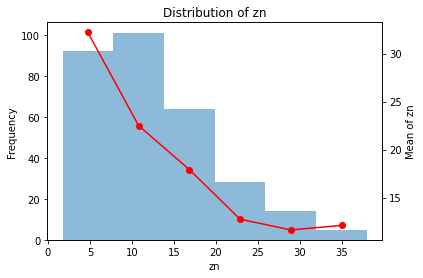

In [28]:
f = 'lstat'
b = 6

mean_b = train_data.groupby(pd.cut(train_data[f],b)).mean()
# 繪製子圖1：直方圖
# axs[0, 0].hist(data[feature_name], bins=10)
# axs[0, 0].set_title(feature_name + ' Distribution')

# 绘制左轴（A的直方图）
#ax1 = axs()

plt.hist(train_data[f], bins=b, alpha=0.5)
plt.xlabel('zn')
plt.ylabel('Frequency')
plt.title('Distribution of '+ 'zn')

# 创建右轴（B的平均值）
plt.twinx()
plt.plot(mean_b.index.categories.mid, mean_b['medv'], color='r', marker='o')
plt.ylabel('Mean of '+'zn')

In [29]:
def trans_qtile (data, column, bin):
    data['temp'] = pd.cut(data[column], bin)
    data['temp_avg'] = data.groupby('temp')[column].transform('mean')
    data[column] = data['temp_avg']
    data = data.drop(['temp','temp_avg'], axis=1)
    return data


In [30]:
new_train_data = train_data.copy()

new_train_data.loc[new_train_data['crim'] >=30,'crim'] = 30

new_train_data = trans_qtile(new_train_data,'zn',10)
new_train_data = trans_qtile(new_train_data,'indus',10)

new_train_data['chas_0'] = 0
new_train_data['chas_1'] = 0

new_train_data.loc[new_train_data['chas'] == 1, 'chas_0'] = 1
new_train_data.loc[new_train_data['chas'] == 1, 'chas_1'] = 1
new_train_data.drop('chas', axis=1)

new_train_data = trans_qtile(new_train_data,'nox',10)
new_train_data = trans_qtile(new_train_data,'rm',10)
new_train_data = trans_qtile(new_train_data,'age',10)
new_train_data = trans_qtile(new_train_data,'dis',10)
new_train_data = trans_qtile(new_train_data,'black',10)
new_train_data = trans_qtile(new_train_data,'tax',10)
new_train_data = trans_qtile(new_train_data,'ptratio',10)
new_train_data = trans_qtile(new_train_data,'lstat',10)

In [63]:

t_data = new_train_data[feature]
X_train, X_val, y_train,y_val = model_selection.train_test_split(t_data, t_labels, test_size=0.5)

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from xgboost import XGBRegressor
regressors = [
   LinearRegression(), 
   RandomForestRegressor(), 
   AdaBoostRegressor(), 
   BaggingRegressor(),
   XGBRegressor(objective='reg:squarederror', eval_metric = 'rmse', gamma = 20)
]

for r in regressors:
   pipeline = Pipeline(steps = [
                  ('preprocessor', preprocessor)
               ,('regressor',r)
            ])
   r.fit(X_train, y_train)
   train_pre = r.predict(X_train)
   val_pre = r.predict(X_val)
   print(r)
   print(metrics.mean_squared_error(train_pre, y_train)**0.5)
   print(metrics.mean_squared_error(val_pre, y_val)**0.5)


LinearRegression()
3.6493619030447824
6.389348591520663
RandomForestRegressor()
1.4523079681012965
5.58525700004744
AdaBoostRegressor()
2.2316239999084364
5.3709100803311935
BaggingRegressor()
1.4608847355374466
5.749687462902017
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
1.5851946970884587
5.59692122

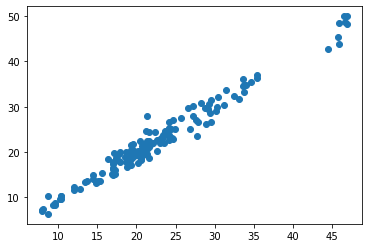

In [65]:
plt.scatter(train_pre,y_train)

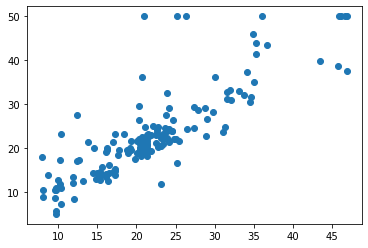

In [66]:
plt.scatter(val_pre,y_val)

In [67]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'reg:squarederror',  # Regression task with mean squared error
    'eval_metric': 'rmse'  # Evaluation metric is root mean squared error
}

In [68]:
# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Regression task with mean squared error
    'eval_metric': 'rmse',  # Evaluation metric is root mean squared error
    'max_depth': 5,  # Maximum depth of each tree
    'subsample': 0.8,  # Fraction of training samples used for each tree
    'colsample_bytree': 0.8,  # Fraction of features used for each tree
    'reg_alpha': 0.1,  # L1 regularization term
    'reg_lambda': 0.1,  # L2 regularization term
    'min_child_weight': 1,  # Minimum sum of instance weight required to create a new node
    'gamma': 0.1,  # Minimum loss reduction required to make a further partition on a leaf node
    'eta': 0.1  # Learning rate
}

# Train the model with early stopping
model = xgb.train(params, dtrain,
                  num_boost_round=1000,  # Maximum number of boosting rounds
                  early_stopping_rounds=5,  # Stop if the metric doesn't improve for 10 rounds
                  evals=[(dval, 'validation')],  # Validation dataset
                  verbose_eval=True)

# Make predictions on the validation set
y_pred = model.predict(dval)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print("RMSE:", rmse)

[0]	validation-rmse:22.66293
[1]	validation-rmse:20.69699
[2]	validation-rmse:18.99643
[3]	validation-rmse:17.45962
[4]	validation-rmse:16.11242
[5]	validation-rmse:14.92435
[6]	validation-rmse:13.81031
[7]	validation-rmse:12.81795
[8]	validation-rmse:11.93915
[9]	validation-rmse:11.12235
[10]	validation-rmse:10.36935
[11]	validation-rmse:9.76625
[12]	validation-rmse:9.25406
[13]	validation-rmse:8.78594
[14]	validation-rmse:8.40706
[15]	validation-rmse:8.07650
[16]	validation-rmse:7.77679
[17]	validation-rmse:7.52354
[18]	validation-rmse:7.29068
[19]	validation-rmse:7.08580
[20]	validation-rmse:6.92408
[21]	validation-rmse:6.77908
[22]	validation-rmse:6.68912
[23]	validation-rmse:6.58639
[24]	validation-rmse:6.48835
[25]	validation-rmse:6.40704
[26]	validation-rmse:6.32028
[27]	validation-rmse:6.24825
[28]	validation-rmse:6.20347
[29]	validation-rmse:6.16155
[30]	validation-rmse:6.11643
[31]	validation-rmse:6.07106
[32]	validation-rmse:6.04258
[33]	validation-rmse:6.02089
[34]	validati

In [107]:
train_pre = model.predict(dtrain)
val_pre = model.predict(dval)
print(r)
print(metrics.mean_squared_error(train_pre, y_train)**0.5)
print(metrics.mean_squared_error(val_pre, y_val)**0.5)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
0.6551153520338502
2.652908261885047


In [46]:
import numpy as np

arr = np.array([[4,9,5],[3,2,9],[9,9,8]])

In [50]:
np.amin(arr, axis = 0)

array([3, 2, 5])

In [51]:
np.amin(arr, axis=1)

array([4, 2, 8])

In [52]:
np.argmin(arr, axis= 1)

array([0, 1, 2])

In [49]:
np.argmin(arr, axis= 1)

array([0, 1, 2])